In [1]:
#imprt libraries
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [2]:
#import training and testing data sets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('Test_Jan.csv')

In [3]:
#convert date column to datetime format
train_df['Date'] = pd.to_datetime(train_df['datetime'], format='%d-%m-%Y %H:%M')
test_df['Date'] = pd.to_datetime(test_df['datetime'], format='%d-%m-%Y %H:%M')

In [4]:
#create a new data frame using necessary columns from the original data frame
columns = ['datetime','nat_demand','T2M_toc','T2M_san','T2M_dav']
train_df = pd.DataFrame(train_df[columns])
test_df = pd.DataFrame(test_df[columns])

In [5]:
#standardize the data 
scaler = StandardScaler()
target_scaler = StandardScaler()
target_scaler.fit(train_df[['nat_demand']])
train_df[columns[2:]] = scaler.fit_transform(train_df[columns[2:]])
test_df[columns[2:]] = scaler.transform(test_df[columns[2:]]) #use same mean and variance as training data

In [6]:
#select principal components
clms = ['T2M_toc','T2M_san','T2M_dav']
pca = PCA(n_components=2)
pca = pca.fit(train_df[clms])
train_df['pca1'] = pca.transform(train_df[clms])[:,0]
test_df['pca1'] = pca.transform(test_df[clms])[:,0] #use same mean and variance as training data

In [7]:
#setup the input data for model training
features = ['pca1']
window_size = 10
X_train = []
y_train = []
X_test = []
y_test = []

for i in range(len(train_df)-window_size):
    X_train.append(train_df[features].iloc[i:i+window_size].values)
    y_train.append(train_df['nat_demand'][i+window_size])
X_train = np.array(X_train)
y_train = np.array(y_train)

for j in range(len(test_df)-window_size):
    X_test.append(test_df[features].iloc[j:j+window_size].values)
    y_test.append(test_df['nat_demand'][j+window_size])
X_test = np.array(X_test)
y_test = np.array(y_test)


In [10]:
model = Sequential([
    LSTM(50, activation='tanh', input_shape=(window_size, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.fit(X_train, y_train, epochs=30, batch_size=16)

Epoch 1/30
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 1335224.5000
Epoch 2/30
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 1038546.3750
Epoch 3/30
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 792324.5625
Epoch 4/30
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 580910.9375
Epoch 5/30
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 405381.2812
Epoch 6/30
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 266502.1875
Epoch 7/30
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 162384.0781
Epoch 8/30
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 93429.8203
Epoch 9/30
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 53826.6719
Epoch 10/30
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 30458.8242
Epoch 11/30
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 19486.5488
Epoch 12/30
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 15254.6113
Epoch 13/30
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 14099.6514
Epoch 14/30
2736/2736 ━━━━━━

KeyboardInterrupt: 

In [ ]:
#make predictions
predictions = model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [ ]:
predictions.shape

(734, 1)

In [ ]:
reshaped_predictions = predictions.reshape(-1,1)
reshaped_predictions.shape

(734, 1)

In [ ]:

predicted_values = target_scaler.inverse_transform(reshaped_predictions)

In [ ]:
predicted_values.shape

(734, 1)

In [ ]:
a = np.concatenate((X_train[-window_size:], X_test), axis=0)


In [ ]:
#make predictions
predictions_2020 = model.predict(a)
reshaped_predictions_2020 = predictions_2020.reshape(-1,1)
predicted_values_2020 = target_scaler.inverse_transform(reshaped_predictions_2020)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
actual_df = pd.read_csv('Predict_Jan.csv')
actual_df.head()

,datetime,nat_demand
0,01-01-2020 00:00,1032.2630
1,01-01-2020 01:00,1017.5806
2,01-01-2020 02:00,1000.2797
3,01-01-2020 03:00,987.2383
4,01-01-2020 04:00,970.3667


In [ ]:
actual_df['predicted_demand'] = predicted_values_2020

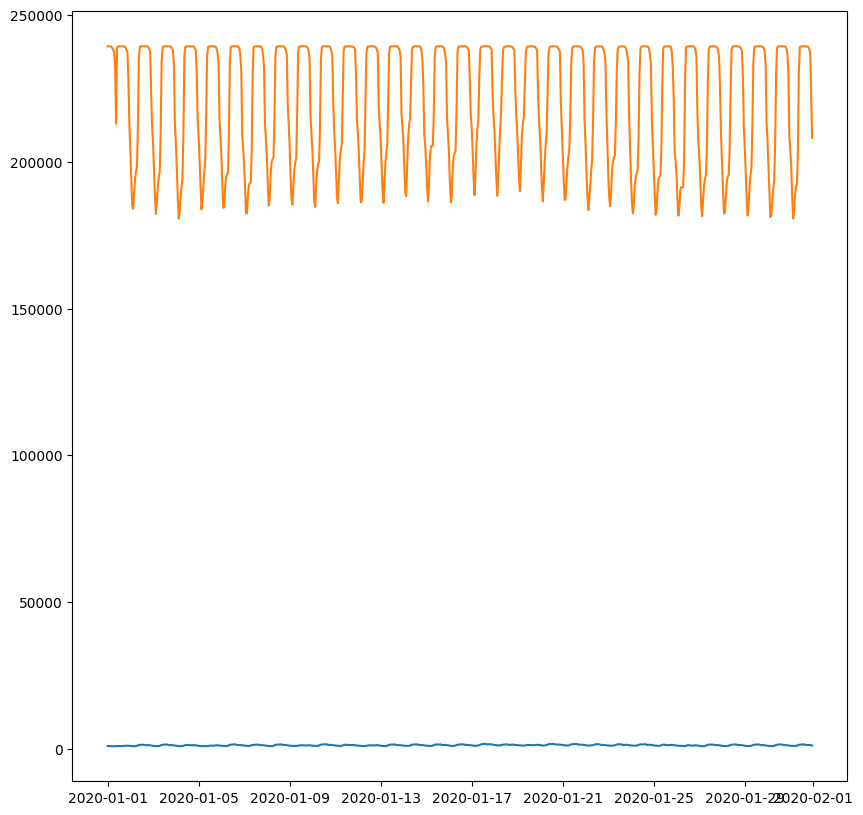

In [ ]:
#plot actual with predicted
actual_df['datetime'] = pd.to_datetime(actual_df['datetime'],format='%d-%m-%Y %H:%M')
plt.figure(figsize=(10,10))
plt.plot(actual_df['datetime'],actual_df['nat_demand'])
plt.plot(actual_df['datetime'],actual_df['predicted_demand'])

plt.show()

In [ ]:
predicted_values_2020

array([[239320.  ],
       [239325.06],
       [239320.92],
       [239296.73],
       [239198.22],
       [238760.73],
       [238102.38],
       [237264.86],
       [231429.8 ],
       [212952.33],
       [238899.48],
       [239241.25],
       [239298.7 ],
       [239319.22],
       [239327.5 ],
       [239329.3 ],
       [239324.31],
       [239304.08],
       [239220.02],
       [238821.16],
       [238126.2 ],
       [237059.34],
       [227423.66],
       [212453.56],
       [204217.17],
       [193740.66],
       [185390.16],
       [183918.75],
       [189533.36],
       [194246.4 ],
       [196686.73],
       [198198.83],
       [211913.83],
       [234972.9 ],
       [239091.34],
       [239275.48],
       [239315.73],
       [239329.83],
       [239335.81],
       [239337.25],
       [239333.7 ],
       [239320.31],
       [239263.81],
       [238994.14],
       [238455.53],
       [237328.38],
       [223018.03],
       [212030.53],
       [205906.67],
       [197033.36],
